In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     Concatenate, BatchNormalization, Activation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Unzipping the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d abhranta/brain-tumor-detection-mri
zip_ref = zipfile.ZipFile('/content/brain-tumor-detection-mri.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Create directories for splitting the dataset
IMG_PATH = "/content/Brain_Tumor_Detection"
DEST_DIRS = ["TRAIN", "VAL", "TEST"]
for dest in DEST_DIRS:
    os.makedirs(dest, exist_ok=True)

# Split the dataset into TRAIN, VAL, and TEST folders
ignored = {"pred"}
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        class_path = os.path.join(IMG_PATH, CLASS)
        if not os.path.isdir(class_path) or CLASS.startswith('.'):
            continue

        # Create subdirectories in TRAIN, VAL, and TEST
        for dest in DEST_DIRS:
            os.makedirs(os.path.join(dest, CLASS.upper()), exist_ok=True)

        IMG_NUM = len(os.listdir(class_path))
        for n, FILE_NAME in enumerate(os.listdir(class_path)):
            img = os.path.join(class_path, FILE_NAME)
            if n < 300:  # First 300 images go to TEST
                shutil.copy(img, os.path.join('TEST', CLASS.upper(), FILE_NAME))
            elif n < 0.8 * IMG_NUM:  # Next 80% of remaining images go to TRAIN
                shutil.copy(img, os.path.join('TRAIN', CLASS.upper(), FILE_NAME))
            else:  # Remaining images go to VAL
                shutil.copy(img, os.path.join('VAL', CLASS.upper(), FILE_NAME))

print("Data successfully split into TRAIN, VAL, and TEST folders.")

# Generate binary masks for images
mask_path = "/content/MASKS"
os.makedirs(mask_path, exist_ok=True)

# Create mask directories for TRAIN, VAL, and TEST
for dest in ["TRAIN", "VAL", "TEST"]:
    os.makedirs(os.path.join(mask_path, dest, "YES"), exist_ok=True)
    os.makedirs(os.path.join(mask_path, dest, "NO"), exist_ok=True)

# Helper function to create binary masks
def create_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    return mask

# Generate and save masks
for split in ["TRAIN", "VAL", "TEST"]:
    for label in ["YES", "NO"]:
        image_dir = os.path.join("/content", split, label)
        mask_dir = os.path.join(mask_path, split, label)

        for img_name in tqdm(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            mask = create_mask(img)
            mask_name = img_name.split('.')[0] + '_mask.png'
            mask_save_path = os.path.join(mask_dir, mask_name)
            cv2.imwrite(mask_save_path, mask)

print("Mask generation complete!")

# Define the image size
IMAGE_SIZE = [128, 128]

# Add data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Load the datasets with augmentation
def load_dataset(image_dir, mask_dir, batch_size=32):
    def preprocess_image(img, mask):
        img = tf.image.resize(img, IMAGE_SIZE)
        mask = tf.image.resize(mask, IMAGE_SIZE)
        img = tf.cast(img / 255.0, tf.float32)
        mask = tf.cast(mask / 255.0, tf.float32)
        return img, mask

    image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,
        label_mode=None,
        image_size=IMAGE_SIZE,
        batch_size=batch_size,
        color_mode='grayscale'
    )

    mask_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        mask_dir,
        label_mode=None,
        image_size=IMAGE_SIZE,
        batch_size=batch_size,
        color_mode='grayscale'
    )

    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
    dataset = dataset.map(preprocess_image)
    return dataset


# Load the datasets
train_image_dir = '/content/TRAIN/'
train_mask_dir = '/content/MASKS/TRAIN/'  # Masks are now in /content/MASKS/TRAIN
valid_image_dir = '/content/VAL/'
valid_mask_dir = '/content/MASKS/VAL/'

train_ds = load_dataset(train_image_dir, train_mask_dir)
validation_ds = load_dataset(valid_image_dir, valid_mask_dir)

# Build U-Net model
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

model = build_unet(input_shape=(128, 128, 1))  # Input shape for grayscale images
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
100% 64.0M/64.3M [00:05<00:00, 19.5MB/s]
100% 64.3M/64.3M [00:05<00:00, 12.8MB/s]
Data successfully split into TRAIN, VAL, and TEST folders.


100%|██████████| 300/300 [00:00<00:00, 714.51it/s]

Mask generation complete!
Found 1800 files.


Found 1800 files.
Found 600 files.
Found 600 files.


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
model.fit(train_ds, epochs=10, validation_data=validation_ds)



Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6548 - loss: 0.5661 - val_accuracy: 0.1773 - val_loss: 71.0460
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 529ms/step - accuracy: 0.7255 - loss: 0.4766 - val_accuracy: 0.7203 - val_loss: 1.8519
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 486ms/step - accuracy: 0.7330 - loss: 0.4645 - val_accuracy: 0.5080 - val_loss: 0.8988
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 491ms/step - accuracy: 0.7303 - loss: 0.4598 - val_accuracy: 0.6993 - val_loss: 0.5089
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.7354 - loss: 0.4575 - val_accuracy: 0.6617 - val_loss: 0.5083
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - accuracy: 0.7332 - loss: 0.4601 - val_accuracy: 0.7123 - val_loss: 0.5138
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 523ms/step - accuracy: 0.7313 - loss: 0.4578 - val_accuracy: 0.7166 - val_loss: 0.4903
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 492ms/step - accuracy: 0.7339 - loss: 0.4565 - val_accur

In [ ]:
# Evaluate the model on the test set
test_image_dir = '/content/TEST/'
test_mask_dir = '/content/MASKS/TEST/'

test_ds = load_dataset(test_image_dir, test_mask_dir)
test_loss, test_acc = model.evaluate(test_ds)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Found 600 files.
Found 600 files.
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6926 - loss: 0.4976
Test Loss: 0.4918733239173889, Test Accuracy: 0.6941675543785095


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


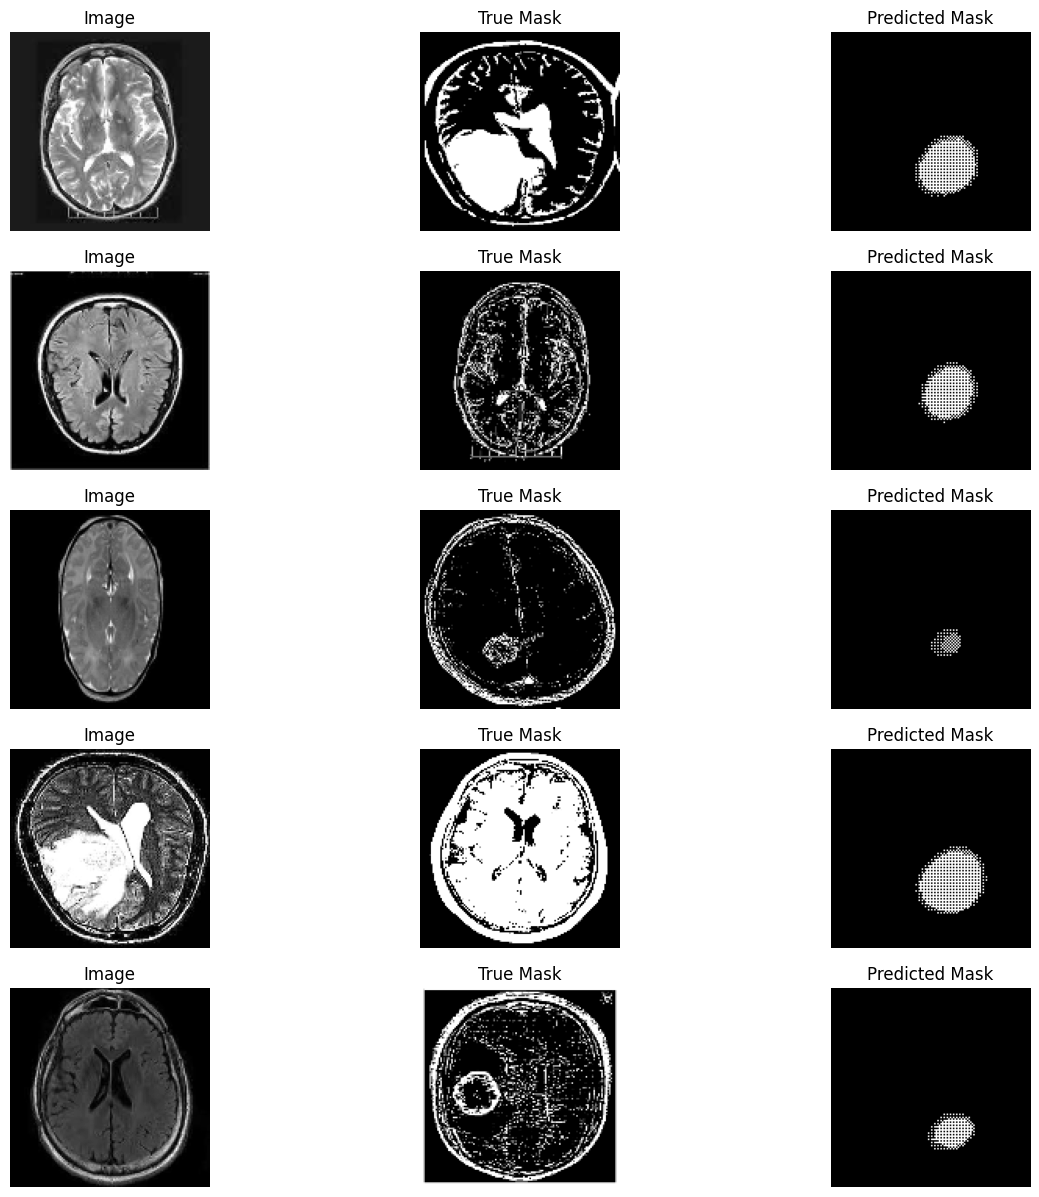

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_images=5):
    for images, masks in dataset.take(1):
        pred_masks = model.predict(images)
        pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Binarize predictions

        fig, axs = plt.subplots(num_images, 3, figsize=(15, 3 * num_images))
        for i in range(num_images):
            axs[i, 0].imshow(images[i, ..., 0], cmap='gray')
            axs[i, 0].set_title('Image')
            axs[i, 1].imshow(masks[i, ..., 0], cmap='gray')
            axs[i, 1].set_title('True Mask')
            axs[i, 2].imshow(pred_masks[i, ..., 0], cmap='gray')
            axs[i, 2].set_title('Predicted Mask')

            # Add visual debugging
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
            axs[i, 2].axis('off')

        plt.show()

# Visualize predictions
visualize_predictions(test_ds, model)


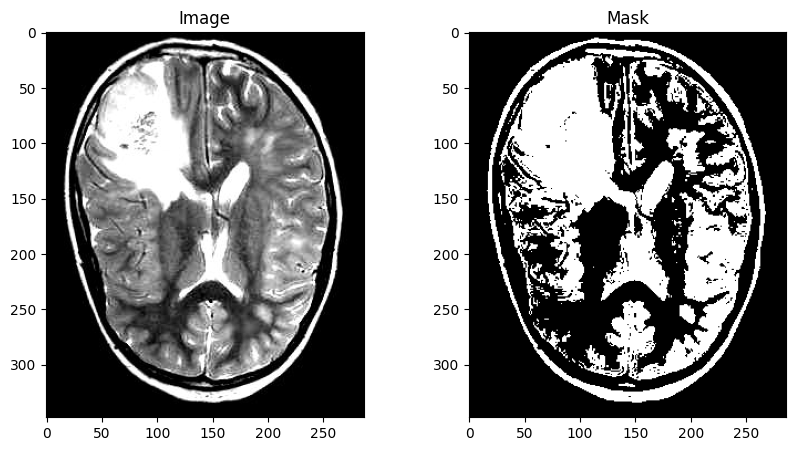

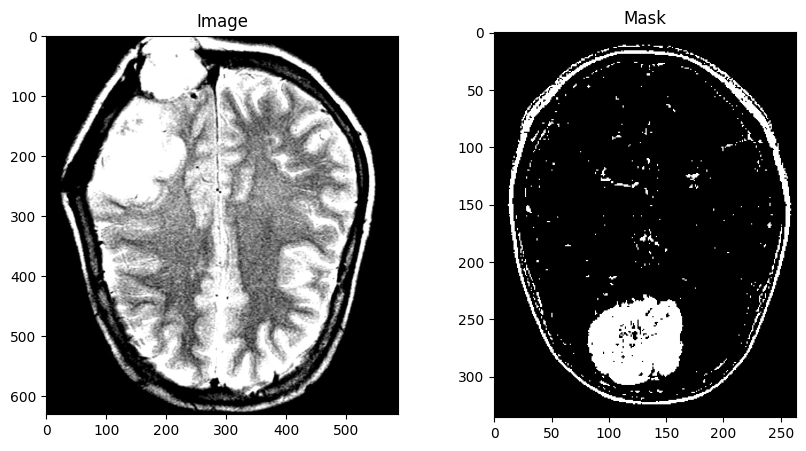

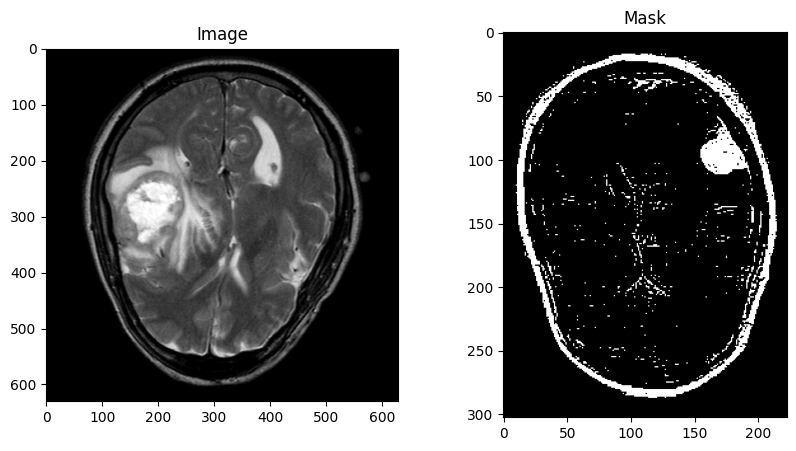

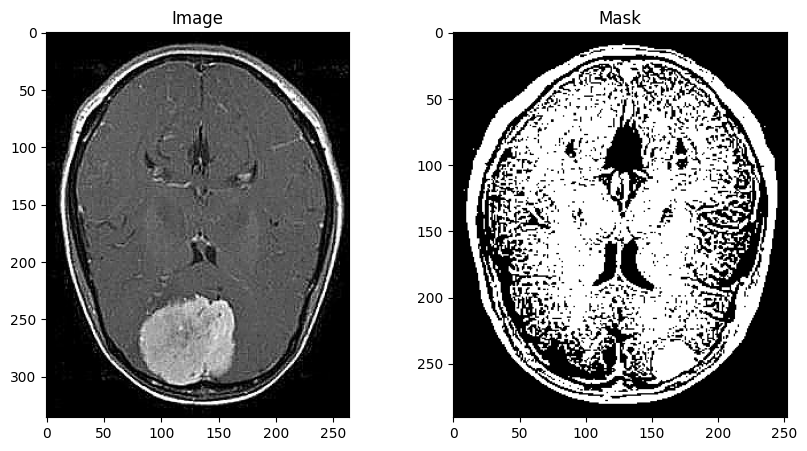

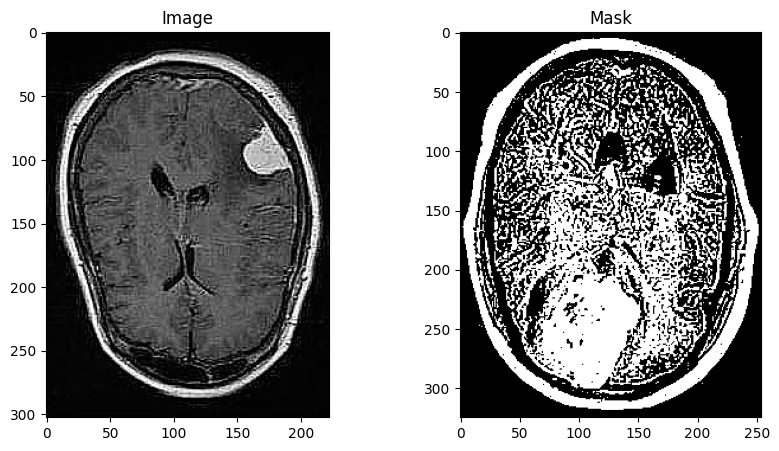

In [ ]:
import matplotlib.pyplot as plt

def check_data_alignment(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for i in range(num_samples):
        img = cv2.imread(os.path.join(image_dir, image_files[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_files[i]), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(img, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')

        plt.show()

# Example usage
check_data_alignment('/content/TRAIN/YES', '/content/MASKS/TRAIN/YES')


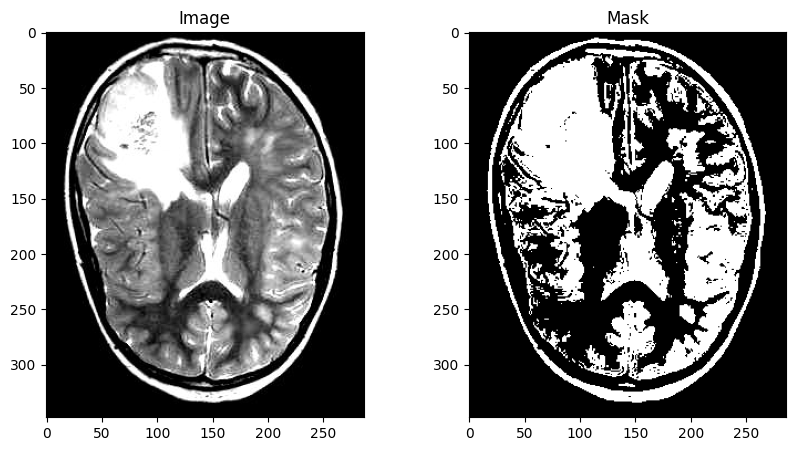

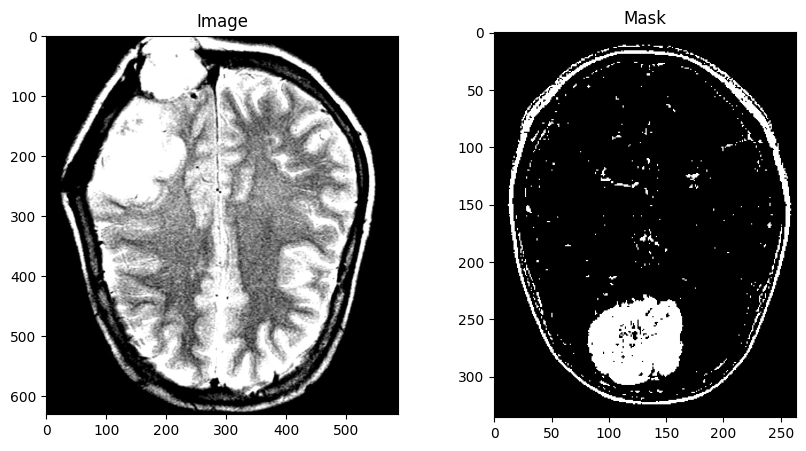

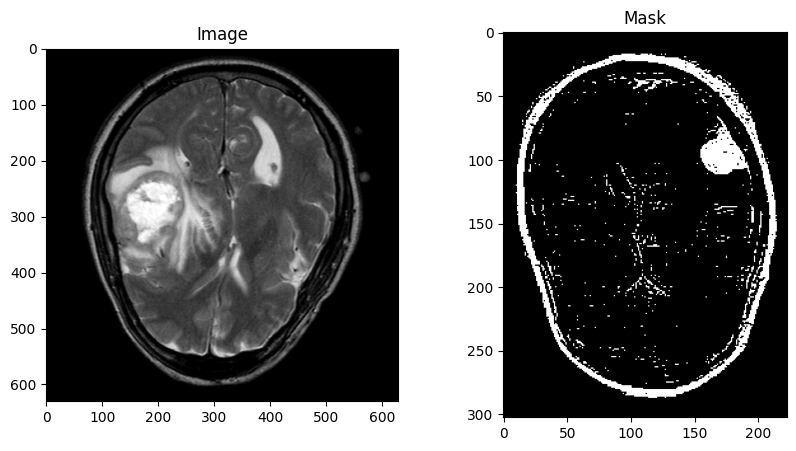

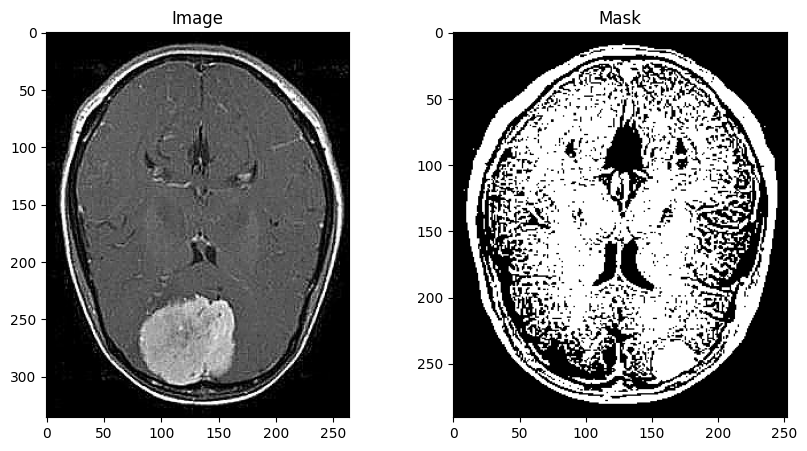

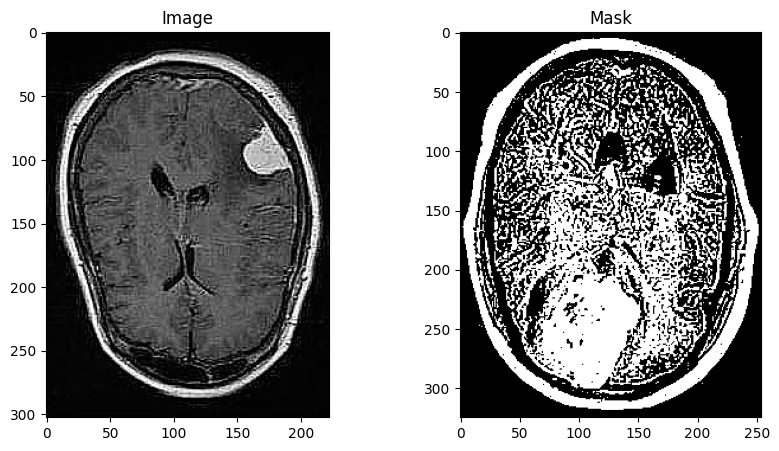

In [ ]:
import matplotlib.pyplot as plt

def check_data_alignment(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for i in range(num_samples):
        img = cv2.imread(os.path.join(image_dir, image_files[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_files[i]), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(img, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')

        plt.show()

# Example usage
check_data_alignment('/content/TRAIN/YES', '/content/MASKS/TRAIN/YES')


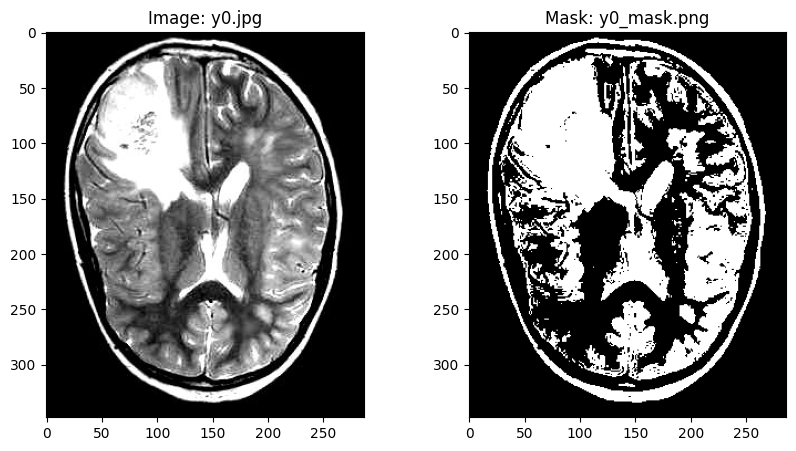

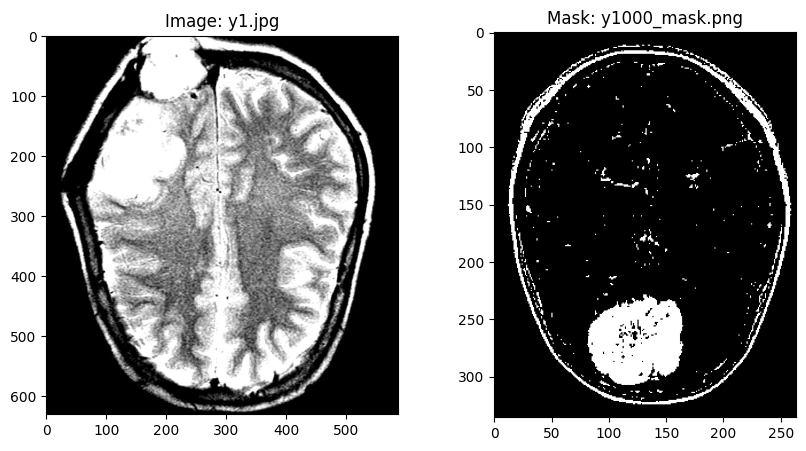

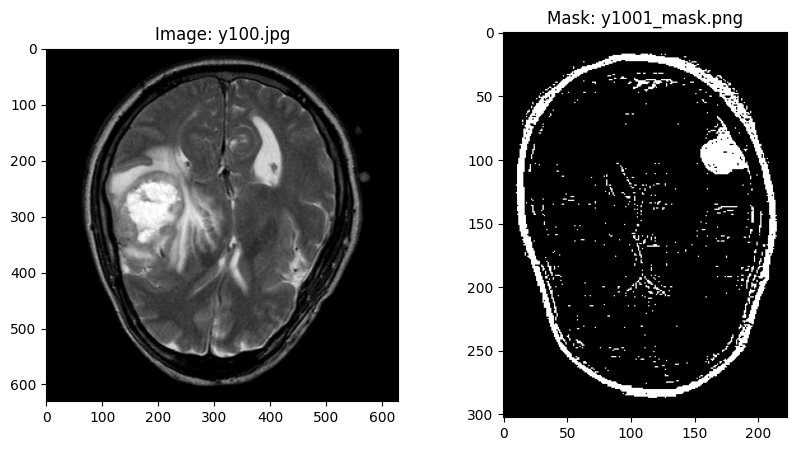

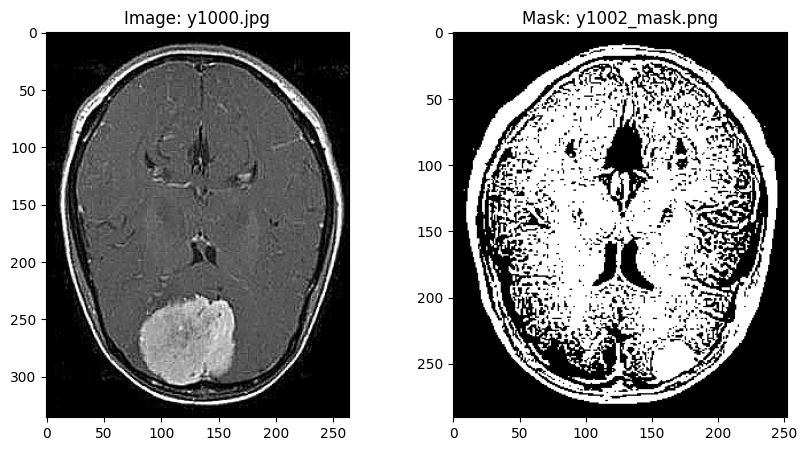

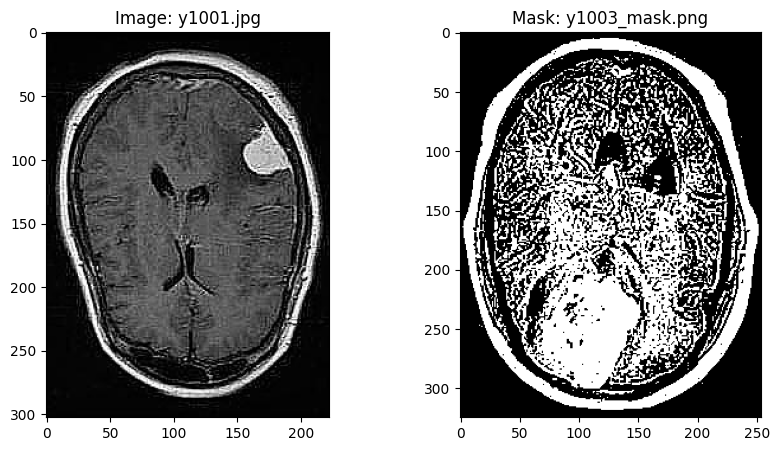

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def visualize_image_mask_pairs(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for i in range(num_samples):
        img = cv2.imread(os.path.join(image_dir, image_files[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_files[i]), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Image: {image_files[i]}')
        plt.imshow(img, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Mask: {mask_files[i]}')
        plt.imshow(mask, cmap='gray')

        plt.show()

# Example usage
visualize_image_mask_pairs('/content/TRAIN/YES', '/content/MASKS/TRAIN/YES')


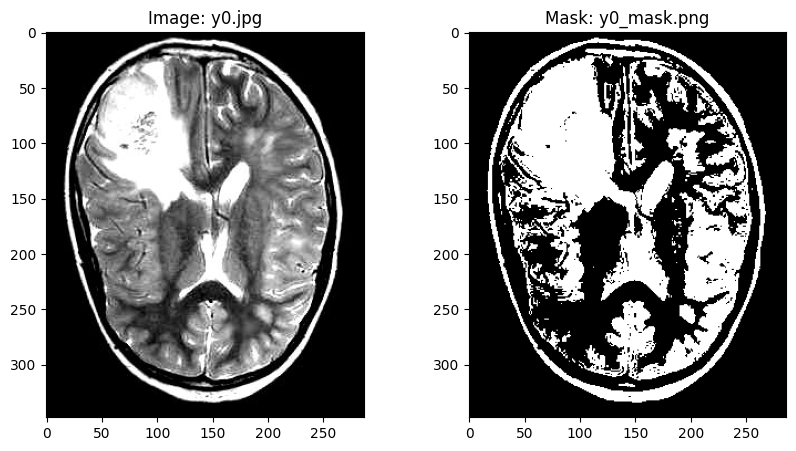

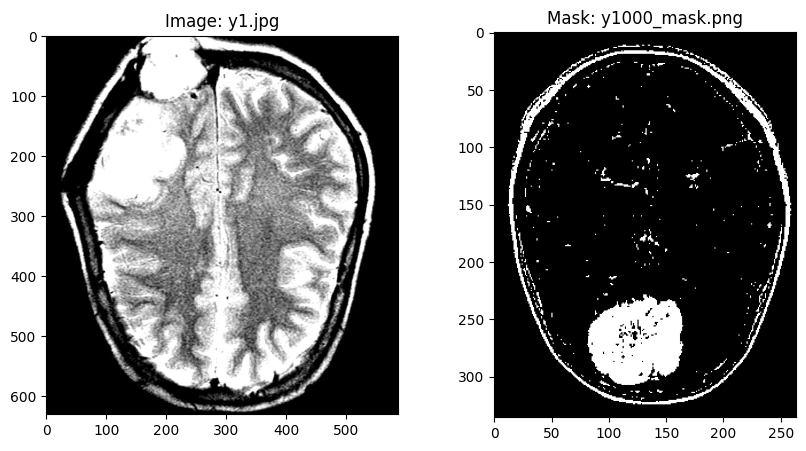

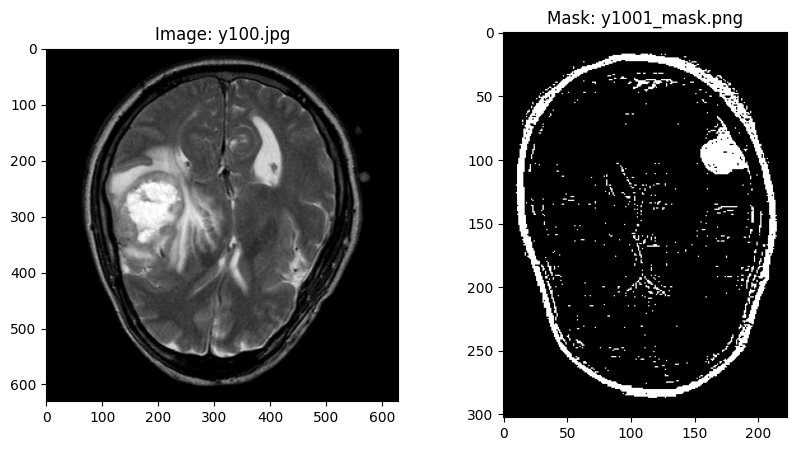

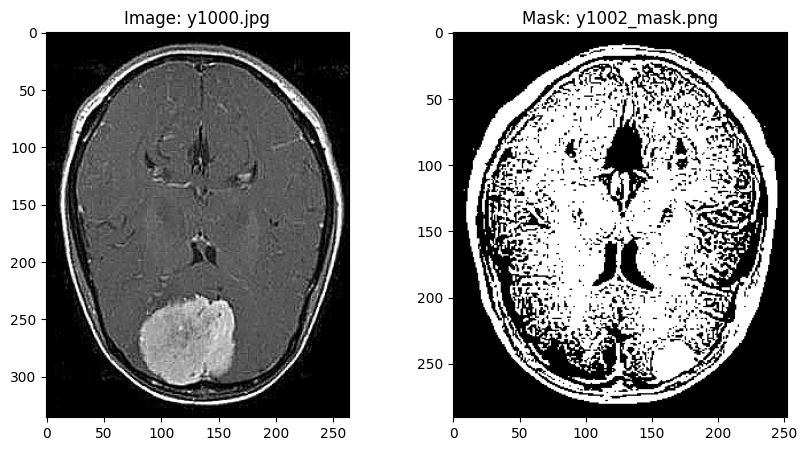

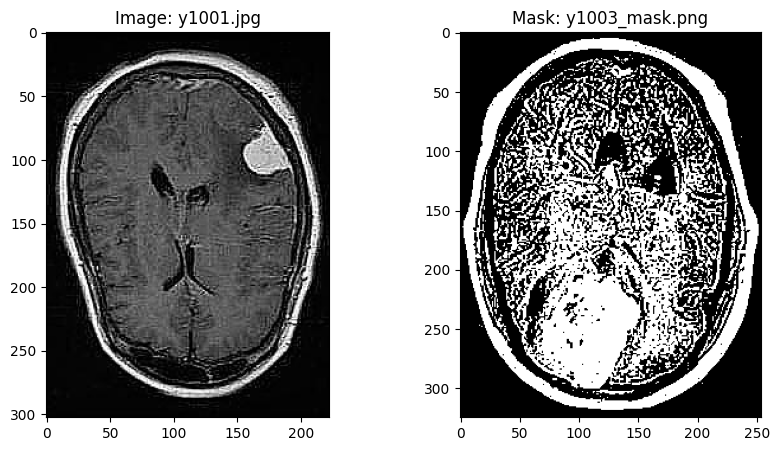

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def visualize_image_mask_pairs(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for i in range(num_samples):
        image_file = image_files[i]
        mask_file = mask_files[i]

        img = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Image: {image_file}')
        plt.imshow(img, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Mask: {mask_file}')
        plt.imshow(mask, cmap='gray')

        plt.show()

# Example usage
visualize_image_mask_pairs('/content/TRAIN/YES', '/content/MASKS/TRAIN/YES')



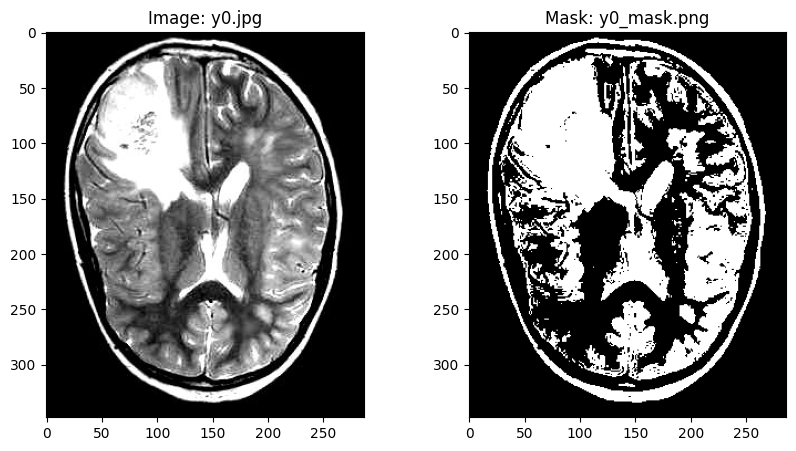

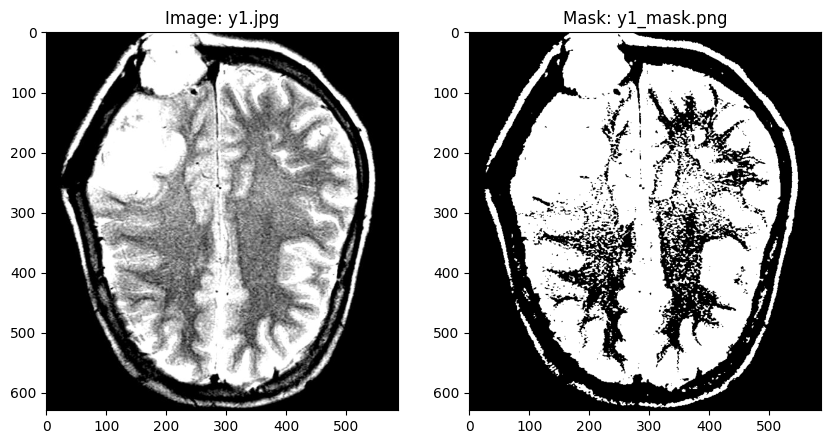

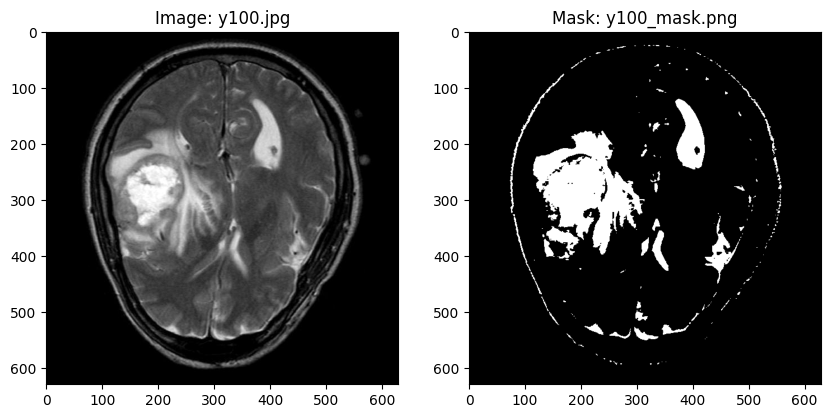

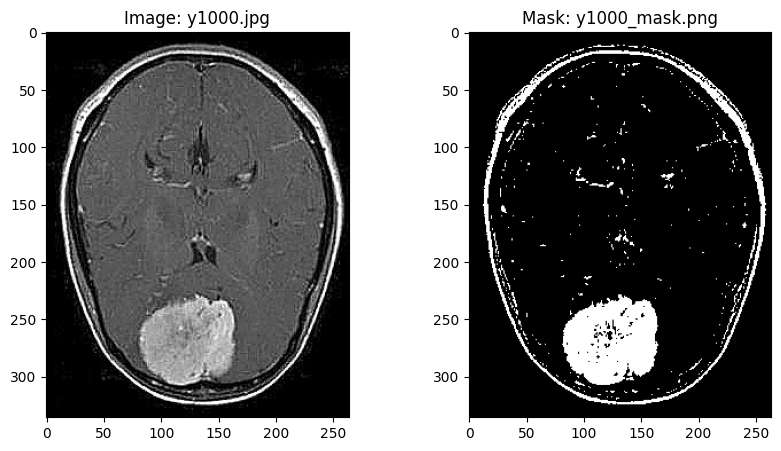

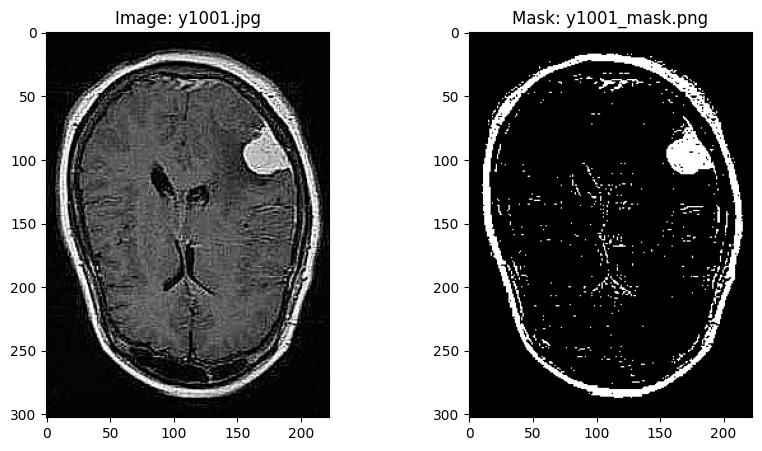

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_match_images_masks(image_dir, mask_dir):
    images = sorted(os.listdir(image_dir))
    masks = sorted(os.listdir(mask_dir))

    paired_files = []

    for image_file in images:
        image_name = os.path.splitext(image_file)[0]  # Get the base name without extension
        matching_mask = image_name + "_mask.png"  # Construct the expected mask filename

        if matching_mask in masks:
            paired_files.append((image_file, matching_mask))
        else:
            print(f"No matching mask found for {image_file}")

    return paired_files

def visualize_paired_images_masks(image_dir, mask_dir, paired_files, num_samples=5):
    for i in range(num_samples):
        image_file, mask_file = paired_files[i]

        img = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Image: {image_file}')
        plt.imshow(img, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Mask: {mask_file}')
        plt.imshow(mask, cmap='gray')

        plt.show()

# Example usage
image_dir = '/content/TRAIN/YES'
mask_dir = '/content/MASKS/TRAIN/YES'

paired_files = load_and_match_images_masks(image_dir, mask_dir)
visualize_paired_images_masks(image_dir, mask_dir, paired_files)
